In [ ]:
!pip install pycuda

In [ ]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from PIL import Image
import matplotlib.pyplot as plt
import time

In [34]:
#Define Cude C Kernel

cuda_kernel_source= """
__global__ void image_blur(unsigned char *in, unsigned char *out, int width, int height,int channels)
{
  int BLUR_SIZE = 2;
  int col = blockIdx.x*blockDim.x + threadIdx.x;
  int row = blockIdx.y*blockDim.y + threadIdx.y;

  if (col<width && row<height)
      {
            int pixVal[3] = {0, 0, 0};
            int pixels = 0;
            // Get average of the surrounding BLUR_SIZE x BLUR_SIZE box

            for (int blurRow = -BLUR_SIZE; blurRow<BLUR_SIZE+1; ++blurRow )

                {

                  for (int blurCol = -BLUR_SIZE; blurCol<BLUR_SIZE+1; ++blurCol )

                      {

                        int curRow = row + blurRow;
                        int curCol = col + blurCol;

                        // verify that we have a valid pixel

                        if (curRow>=0 && curRow <height && curCol >=0 && curCol <width)

                            {
                              int idx =(curRow*width + curCol)*channels;

                                for (int c =0; c<channels;c++)
                                {
                                  pixVal[c]+=(float)in[idx+c];
                                }

                              ++pixels;
                            }
                       }
                  }

          int out_idx =(row*width + col)*channels;

          for (int c =0; c<channels;c++)

              {
                  out[out_idx + c]= static_cast<unsigned char>(pixVal[c]/pixels);
              }

      }
}

"""

In [35]:
print("Compiling the CUDA Kernel....")
#compile the cuda

mode =  SourceModule(cuda_kernel_source)

#Get the compiler function from the compile module
image_blur= mode.get_function('image_blur')


print("kernel compiled successfully")

Compiling the CUDA Kernel....
kernel compiled successfully


The matrix of Bukayo Saka is now initialised


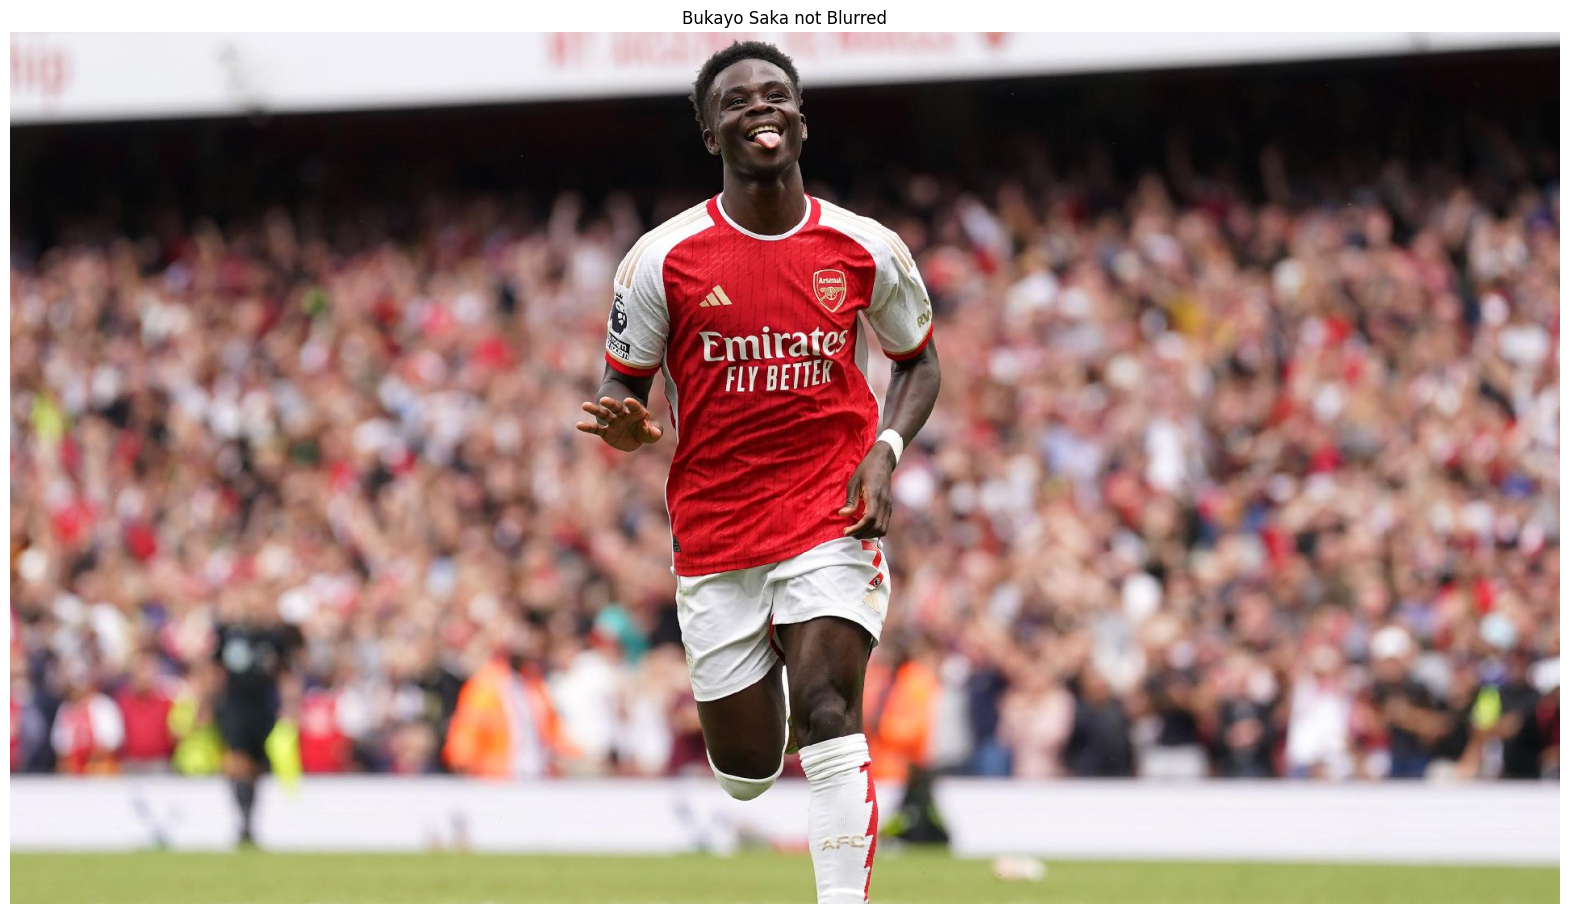

In [2]:
#Load the image
image = np.array(Image.open('1696296-bukayo-saka-nets-stunner-before-arsenal-forced-to-cling-on-to-beat-forest.jpg'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka not Blurred")
ax.imshow(image)
print("The matrix of Bukayo Saka is now initialised")

In [37]:
#print the shape of the input array
print(f'The shape of the input array is {image.shape}')

#Initialise an empy array for result
empty_sample_output=np.empty_like(image)

print('\nEmpty output image is initialised')

The shape of the input array is (1080, 1920, 3)

Empty output image is initialised


In [38]:
#Allocate memory in GPY

p_in= cuda.mem_alloc(image.nbytes)
p_out=cuda.mem_alloc(empty_sample_output.nbytes)

print("memory allocated in GPU")

memory allocated in GPU


In [39]:
#Transfer Data from CPu to Gpu
print("Copy the image to GPU form the CPU")
cuda.memcpy_htod(p_in,image)
print("\nCopying completed")

Copy the image to GPU form the CPU

Copying completed


In [40]:
#Execute the kernel in GPU
print("\nExecuting the parallel programming in GPU")
#Define the Block and grid dimension in GPU to process
# A block is a group of  threads . A grid is a group of blocks
BLOCK_SIZE=(16,16,1)
GRID_SIZE = (
    (image.shape[1]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0],
    (image.shape[0]+BLOCK_SIZE[0]-1)//BLOCK_SIZE[0]
    )

#Start the time

gpu_start_time= time.time()

#Call the Kernel
image_blur(p_in,p_out,np.int32(image.shape[1]),np.int32(image.shape[0]),np.int32(image.shape[2]),block =BLOCK_SIZE,grid=GRID_SIZE)

#Wait for the GPU to Finish the Process
cuda.Context.synchronize()

#stop the timer
gpu_endtime= time.time()

gpu_execution_time=(gpu_endtime-gpu_start_time)
print("\nExection in GPU completed :)")




Executing the parallel programming in GPU

Exection in GPU completed :)


In [41]:
#Copying the result from thr GPU to CPU
print("Copying the result back to CPU")
empty_sample_output=np.empty_like(image)
cuda.memcpy_dtoh(empty_sample_output,p_out)
print("copied successfully to CPU")


Copying the result back to CPU
copied successfully to CPU


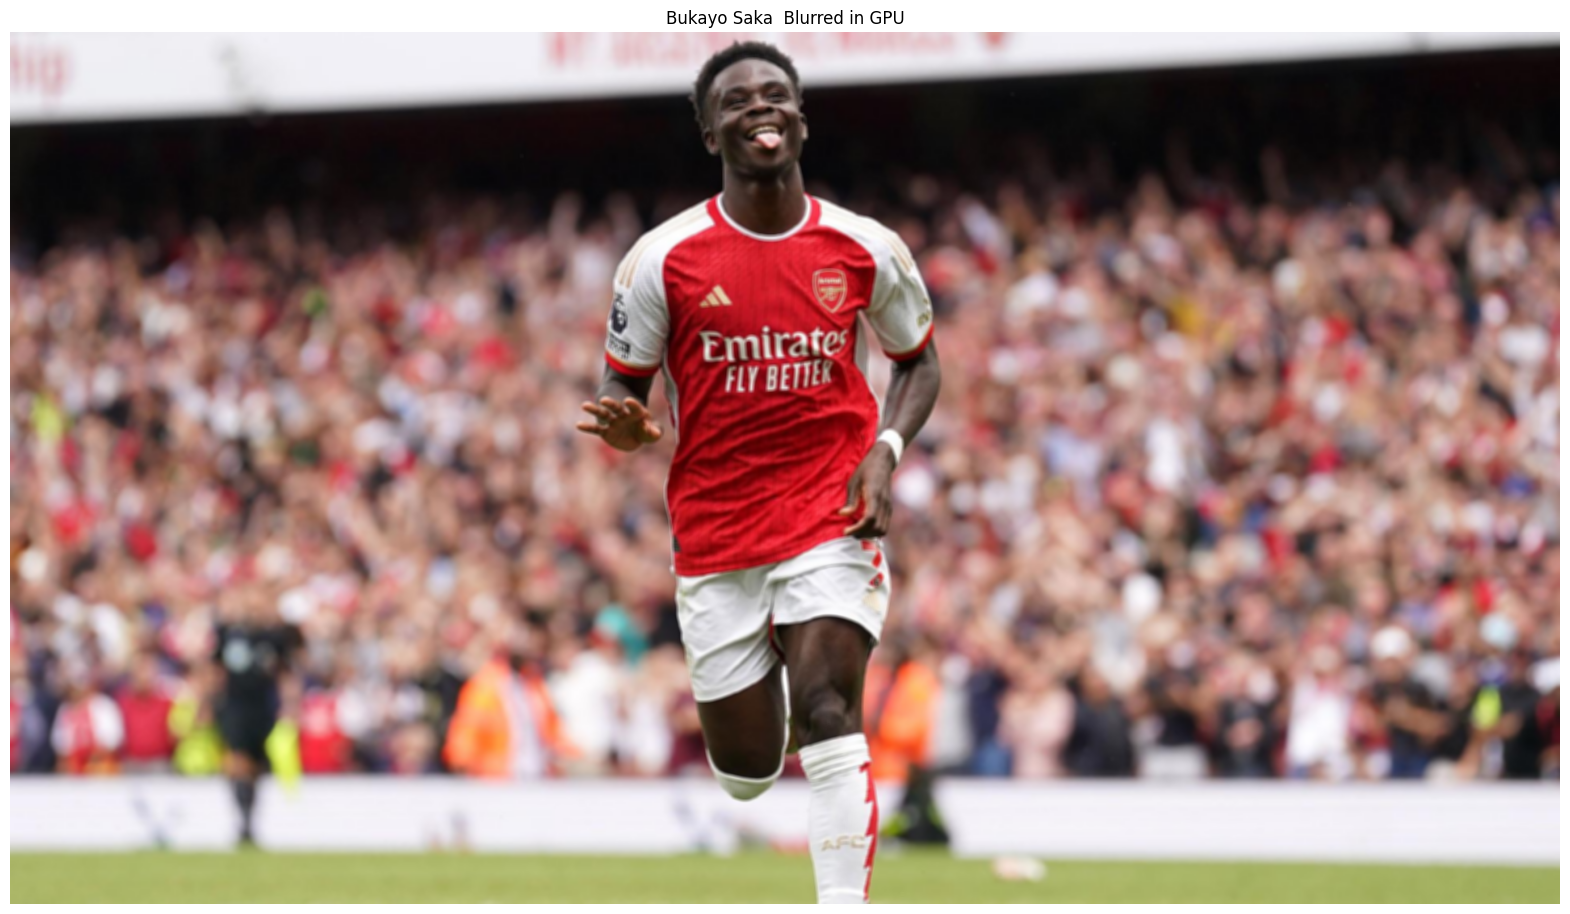

The matrix of Bukayo Saka is now is the blurred matrix


In [42]:
#Show the blurred Bukayo Saka
axes= plt.Figure(figsize=(10,9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka  Blurred in GPU")
ax.imshow(empty_sample_output)
plt.axis("off")
plt.show()
print("The matrix of Bukayo Saka is now is the blurred matrix")

In [43]:
empty_sample_output.shape

(1080, 1920, 3)

In [4]:
BLUR_SIZE=2

#Initialise an empy array for result
empty_sample_output=np.empty_like(image)

cpu_starttime=time.time()
# Blurring in CPU
for row in range(0,image.shape[0]):

  for col in range(0,image.shape[1]):
    pixel_val=np.zeros(3, dtype=np.int32)
    n_pixel=0

    for blurcol in range(-BLUR_SIZE,BLUR_SIZE+1):

      for blurrow in range(-BLUR_SIZE,BLUR_SIZE+1):
        b_col =col+blurcol
        b_row =row+blurrow

        if (b_col>=0)and(b_col<image.shape[1])and(b_row>=0)and(b_row<image.shape[0]):
          pixel_val += image[b_row, b_col].astype(np.int32)
          n_pixel+=1

    empty_sample_output[row, col] = (pixel_val // n_pixel).astype(np.uint8)


cpu_endtime=time.time()

time_taken_cpu=cpu_endtime-cpu_starttime


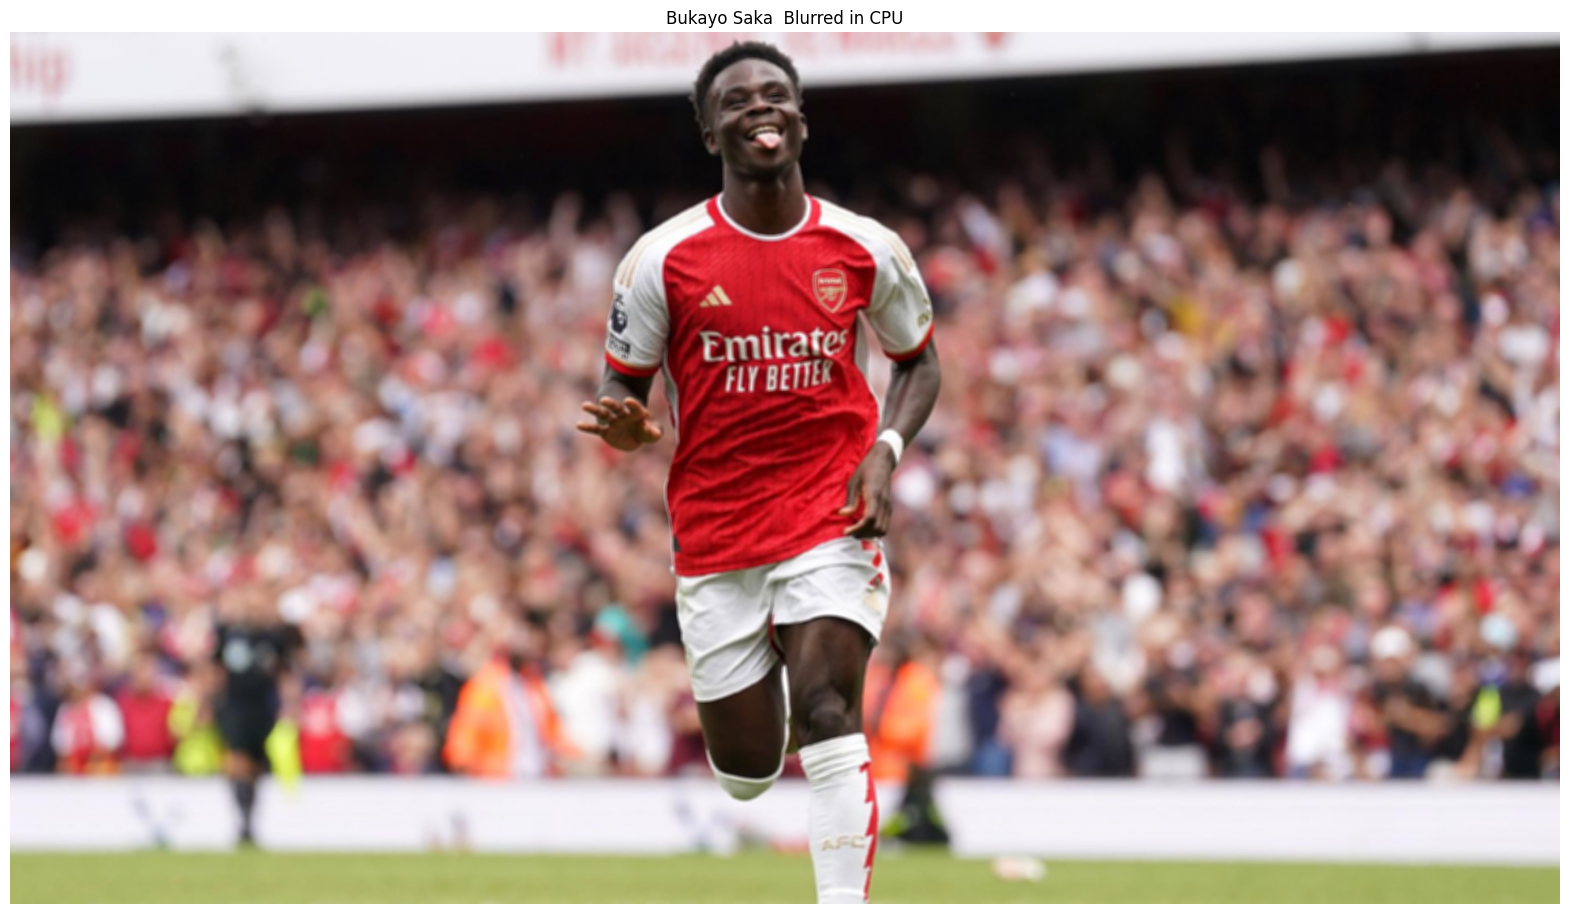

The matrix of Bukayo Saka is now is the blurred matrix


In [5]:
#Show the blurred Bukayo Saka
axes= plt.Figure(figsize=(10,9))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
plt.axis("off")
plt.title("Bukayo Saka  Blurred in CPU")
ax.imshow(empty_sample_output)
plt.axis("off")
plt.show()
print("The matrix of Bukayo Saka is now is the blurred matrix")

In [46]:
print(f"Time taken in GPU is {gpu_execution_time} \nTime taken in CPU is {time_taken_cpu}")

Time taken in GPU is 0.0018665790557861328 
Time taken in CPU is 116.09022641181946
